# "Traffic Violations in Maryland County" — About the data

This is a brief exploration of [a dataset provided by rounak041993 on Kaggle](https://www.kaggle.com/datasets/rounak041993/traffic-violations-in-maryland-county), which contains information for over 1 million traffic violations reported in Montgomery County, Maryland during 2012-2018. The exploration is conducted with the following questions in mind:

1. Which ***colors*** of vehicles were more likely to get involved in a traffic violation?
2. Which ***models*** of vehicles were more likely to get involved in a traffic violation?

Of course, the answers to these questions should not be confused with any sort of causative relationship — without comparative data about the distribution of colors and models for vehicles in Maryland as a whole during 2012-2018, there is little way of telling whether any particular vehicle characteristic is disproportionately common among the cars flagged for traffic violations. The strongest predictor of which cars were involved in traffic violations is likely to be the local popularity of their make, model, and colors.

# Initial data processing

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Traffic_violations.csv', low_memory=False)

In [2]:
print(df.dtypes)

Date Of Stop                object
Time Of Stop                object
Agency                      object
SubAgency                   object
Description                 object
Location                    object
Latitude                   float64
Longitude                  float64
Accident                    object
Belts                       object
Personal Injury             object
Property Damage             object
Fatal                       object
Commercial License          object
HAZMAT                      object
Commercial Vehicle          object
Alcohol                     object
Work Zone                   object
State                       object
VehicleType                 object
Year                       float64
Make                        object
Model                       object
Color                       object
Violation Type              object
Charge                      object
Article                     object
Contributed To Accident     object
Race                

In [29]:
violation_details = df.loc[:, ['Arrest Type', 'Description', 'Violation Type', 'Charge', 'Article', 
                               'Accident', 'Contributed To Accident', 'Personal Injury', 'Property Damage', 
                               'Fatal', 'Alcohol', 'Belts', 'Work Zone', 'Commercial License', 
                               'Commercial Vehicle', 'HAZMAT']]
car_details = df.loc[:, ['VehicleType', 'Make', 'Model', 'Year', 'Color']]

In [4]:
car_details.sample(10, random_state=999)

,VehicleType,Make,Model,Year,Color
586647,02 - Automobile,NISS,SENTRA,2016.0,BLACK
158507,02 - Automobile,CADILLAC,4S,2001.0,WHITE
663735,02 - Automobile,HYUNDAI,SANTA FE,2005.0,SILVER
975154,02 - Automobile,VOLKS,PASSAT,2003.0,SILVER
730763,02 - Automobile,CHEV,4S,2014.0,PURPLE
241901,02 - Automobile,KIA,RIO,2011.0,TAN
738745,02 - Automobile,FORD,FOCUS,2004.0,BLUE
650316,02 - Automobile,TOYOTA,T100,1996.0,WHITE
1010602,02 - Automobile,CHEV,TK,2012.0,SILVER
681474,02 - Automobile,GMC,YUKON,2001.0,GOLD


In [80]:
# (Out of curiosity, how much is in here that *isn't* an automobile?)
print(car_details['VehicleType'].value_counts())

02 - Automobile          1131891
05 - Light Duty Truck      72034
03 - Station Wagon         20635
Name: VehicleType, dtype: int64


For simplicity's sake, the rest of this analysis will be on automobiles and vehicles approximately the same size as noncommercial automobiles, which is still a majority of the dataset.

In [30]:
car_details = car_details.loc[car_details['VehicleType'].isin(['02 - Automobile', '05 - Light Duty Truck', '03 - Station Wagon'])]
len(car_details)

1224560

# Traffic violations by vehicle color

In [31]:
color_counts = car_details['Color'].value_counts()
print("Unique color values:", len(color_counts), "\n")
print(color_counts)

Unique color values: 26 

BLACK          248406
SILVER         230647
WHITE          181426
GRAY           136564
RED             96677
BLUE            90398
GREEN           47359
GOLD            40096
TAN             26402
BLUE, DARK      26191
MAROON          21402
BLUE, LIGHT     16610
BEIGE           14668
GREEN, DK       13977
GREEN, LGT       7020
BROWN            5624
ORANGE           4235
YELLOW           3912
BRONZE           2828
PURPLE           2374
CREAM             805
MULTICOLOR        625
COPPER            393
PINK              176
CHROME             27
CAMOUFLAGE         23
Name: Color, dtype: int64


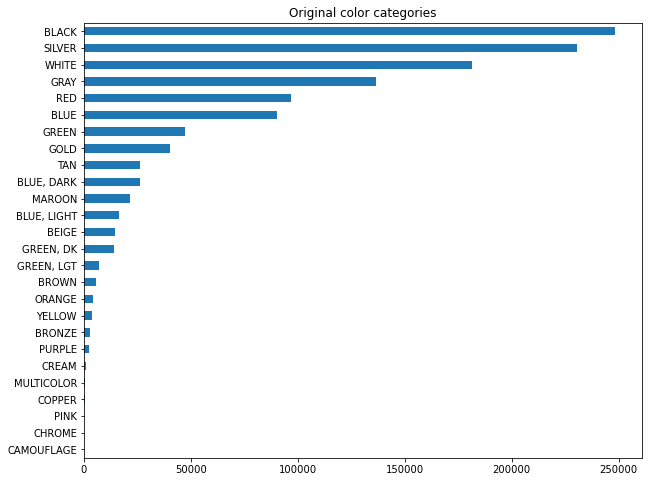

In [68]:
color_counts.sort_values(inplace=True)
color_std_plot = color_counts.plot(kind='barh', figsize=(10,8), title='Original color categories')

By far the most common car colors in this dataset are black, white, and shades of gray, but if anything it would be more surprising if that weren't the case — black, silver, white, and gray are [reportedly some of the most *popular* car colors](https://www.motorbiscuit.com/the-surprisingly-simple-reason-your-next-car-should-be-silver/) as well, so we would expect them to be well-represented in traffic violations.

## Most frequent colors by hue

Let's make the number of categories a bit more manageable by combining colors that seem likely to get mistaken for each other in different lighting, or chosen between arbitrarily:
* 'GREEN, DK' and 'GREEN, LGT' will be folded into 'GREEN'; likewise with 'BLUE'
* 'CHROME' and 'GRAY' are grouped under 'SILVER'
* 'BEIGE' is grouped under 'TAN'
* 'CREAM' is grouped under 'WHITE'
* 'COPPER' is grouped under 'ORANGE'

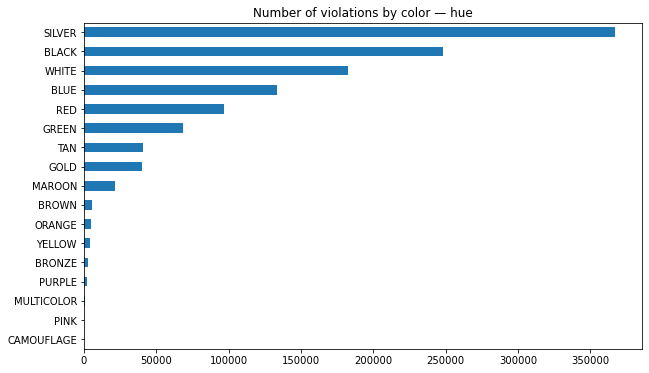

In [33]:
by_color = color_counts.copy()
by_color['SILVER'] += by_color['CHROME'] + by_color['GRAY']
by_color['GREEN'] += by_color['GREEN, DK'] + by_color['GREEN, LGT']
by_color['BLUE'] += by_color['BLUE, LIGHT'] + by_color['BLUE, DARK']
by_color['ORANGE'] += by_color['COPPER']
by_color['TAN'] += by_color['BEIGE'] 
by_color['WHITE'] += by_color['CREAM']
by_color = by_color.drop(index=['CHROME', 'GRAY', 'GREEN, DK', 'GREEN, LGT', 'BLUE, LIGHT', 'BLUE, DARK', 'COPPER', 'BEIGE', 'CREAM'], errors='ignore')

by_color.sort_values(inplace=True)
color_hue_plot = by_color.plot(kind='barh', title='Number of violations by color — hue', figsize=(10,6))

Colors in the silver-to-gray spectrum appear to be more common, which again tracks with general color popularities.

## Most frequent colors by brightness

Since it's frequently assumed that the visibility of someone's car will impact how likely they are to be noticed and pulled over for common violations, I wanted to try a different set of groups:
* Black
* White
* Pale colors: silvery and off-white shades
* Bright pigments: colors marked as "light" for blue and green, plus more unusual eye-catching pigments like pink or multicolor
* Dark pigments: colors marked as "dark" for blue and green, plus maroon which is reliably a darker shade
* The remaining colors I suspect from personal experience are mainly on the darker side, but I have seen occur in both bright and dark shades, so without cross-referencing models with standard paint colors it would be difficult to classify them

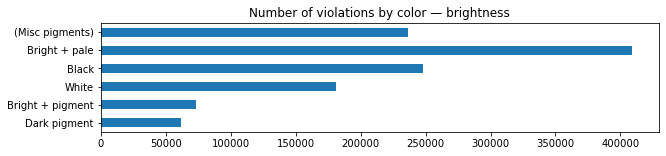

In [34]:
by_bright = pd.Series(dtype='str')
by_bright['Black'] = color_counts['BLACK']
by_bright['Dark pigment'] = color_counts['GREEN, DK'] + color_counts['BLUE, DARK'] + color_counts['MAROON']
by_bright['White'] = color_counts['WHITE']
by_bright['Bright + pale'] = color_counts['TAN'] + color_counts['CREAM'] + color_counts['BEIGE'] + color_counts['SILVER'] + color_counts['CHROME'] + color_counts['GRAY']
by_bright['Bright + pigment'] = color_counts['GREEN, LGT'] + color_counts['BLUE, LIGHT'] + color_counts['ORANGE'] + color_counts['COPPER'] + color_counts['PINK'] + color_counts['MULTICOLOR'] + color_counts['GOLD'] + color_counts['YELLOW']
by_bright.sort_values(inplace=True)
by_bright['(Misc pigments)'] = color_counts['GREEN'] + color_counts['BLUE'] + color_counts['PURPLE'] + color_counts['RED']

color_bright_plot = by_bright.plot(kind='barh', figsize=(10,2), title='Number of violations by color — brightness')

The brighter colors do seem more strongly represented in the dataset, but enough of the car colors are ambiguous in shade that it's hard to draw any strong conclusions.

# Traffic violations by vehicle model

For an initial look at the vehicle model values (on a $log_10$ scale to slightly even out the visual disparity between largest and smallest values):

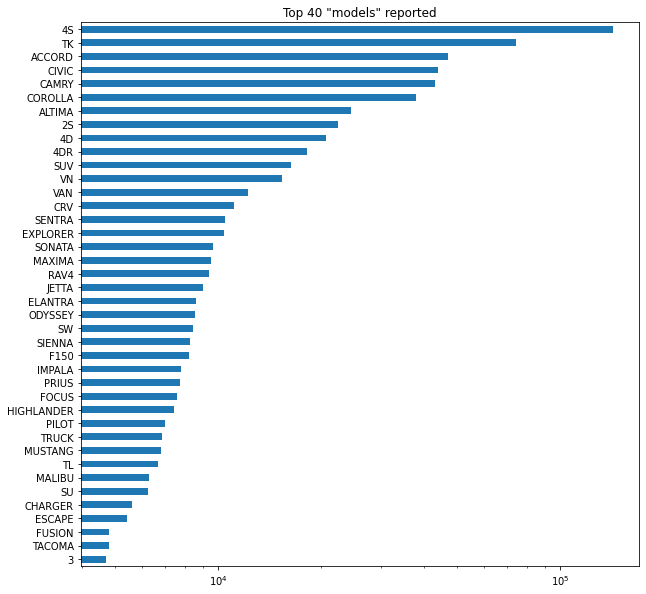

In [79]:
top_40 = car_details['Model'].value_counts()[:40].sort_values()
ax = top_40.plot(kind='barh', figsize=(10,10), title='Top 40 "models" reported', logx=True)

In [36]:
car_details['Model'].value_counts()

4S                 143127
TK                  74429
ACCORD              47055
CIVIC               44043
CAMRY               42907
                    ...  
4H 32V NORTHSTA         1
EQUANOX 4DR             1
VELOS                   1
XC SC                   1
CHARAKEE                1
Name: Model, Length: 15894, dtype: int64

In [37]:
car_details['Make'].value_counts()

TOYOTA         141909
HONDA          133587
FORD           112402
TOYT            70886
NISSAN          66912
                ...  
PMW                 1
CHRL                1
TOYOVAL2008         1
LINCVAL2000         1
GEO/CHEVY           1
Name: Make, Length: 2855, dtype: int64

15,894 unique car models from 2,855 different manufacturers on the road in Maryland, let alone getting involved in traffic violations specifically, seems just a bit unlikely. Some of these are categories of car but not models (e.g. `4S`/`4D`/`4 DOOR` and `TRUCK`/`TK`). There are also definitely misspellings involved here (e.g. `CHARAKEE`) — the question is, are there enough of them to really impact the ordering of car models?

In [11]:
import fuzzywuzzy
from fuzzywuzzy import process

In [56]:
model_counts = car_details['Model'].value_counts()

def get_matches(name, thresh): # return a list of fuzzy matches for the given model name
    match_tups = fuzzywuzzy.process.extract(name, model_counts.index, limit=100, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    close_enough = [match[0] for match in match_tups if match[1] >= thresh]
    return close_enough

# Check for fuzzy matches to the top 30 models, after dropping the values that are categories of car rather than specific models
actual_models = model_counts.drop(['4S', '2S', '3', '2D', '4D', '4DR', '4 DOOR', 'SUV', 'TK', 'TRUCK', 'VAN', 'VN', 'NONE'])
top_models = actual_models.index[:30]
# Ignore any other 2-3 letter entries for now, because they're harder to disambiguate from false matches
top_variants = {top:get_matches(top, 80) for top in top_models if len(top) > 3}
# Manually check over results for any false matches
for k,m in top_variants.items():
    print(f"\n{k}: {model_counts[k]} initially, +{model_counts[m[1:]].sum()} from potential variants\n\t", m)


ACCORD: 47055 initially, +2339 from potential variants
	 ['ACCORD', 'ACCORD`', 'ACCCORD', 'ACCORED', 'ACCORRD', 'ACCOORD', 'ACCORDD', 'AQCCORD', '4ACCORD', 'MACCORD', 'ACCORDQ', 'ACCORDB', 'ACCOERD', 'AACCORD', 'ACCOURD', 'ACCORDA', 'ACCORSD', 'ACCRORD', 'ACCORDG', 'ACCPORD', 'ACORD', 'ACCOR', 'ACCRD', 'CCORD', 'ACCOD', '4SACCORD', 'ACCORD E', '4 ACCORD', 'ACCORD4S', 'ACCORDRT', 'ACCROD', 'ACOORD', 'ACCIRD', 'SCCORD', 'ACCORE', 'ACCPRD', 'AACORD', 'ACCOED', 'ACC0RD', 'ACCORS', 'ACORRD', 'COCORD', 'ACCORG', 'ACCOTD', 'ACORDC', 'ACCORO', 'ACCODR', 'ACCORD 4S', '4S ACCORD', 'ACCORD 4D', 'ACCORD 2S', 'ACCORD 2D', 'ACCORD - 4S', '4S - ACCORD', 'ACCORD LX', '2S ACCORD', 'ACCORD EX', 'ACCORD - 2S', '4S-ACCORD', '4S/ACCORD', '4D ACCORD', '2S - ACCORD', 'ACCORD SW', '4S / ACCORD', 'ACCORD/ 2S', 'ACCORD V6', '4S  ACCORD', 'ACCO', 'ACCORD/ 4S', 'ACCORD  4S', 'ACCD', '2S-ACCORD', 'ACCORD RS', 'ACCORD/2S', 'ACCORD - 2H', 'ACCORD   SX', 'ACCORD DX', 'ACCORD, 4S', 'ACCORD/SW', '4H ACCORD', 'ACCORD R

Most of these look like accurate identification of typos on [fuzzywuzzy](https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)'s part, with just a few potential issues:
* Hyundai Elantra vs Nissan Sentra is apparently a pretty big problem, not just in terms of the fuzzy matcher sometimes struggling to distinguish misspellings of the two, but also apparent human ability to remember that they are two separate brands and models (`SELANTRA`)
* I don't know enough about Ford cars to accurately discern all of the valid model names that look similar to F150, so just going to drop all of the variant spellings — there aren't enough of them to really sway the data either way

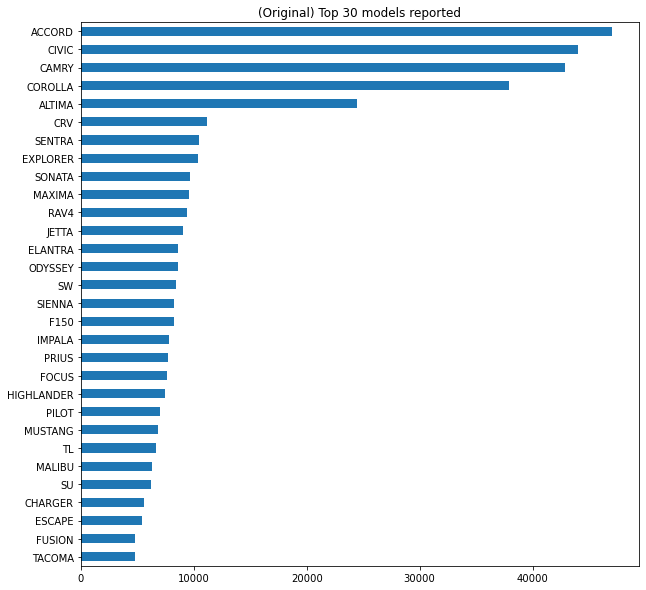

In [81]:
ax = actual_models[:30].sort_values().plot(kind='barh', figsize=(10,10), title='(Original) Top 30 models reported')

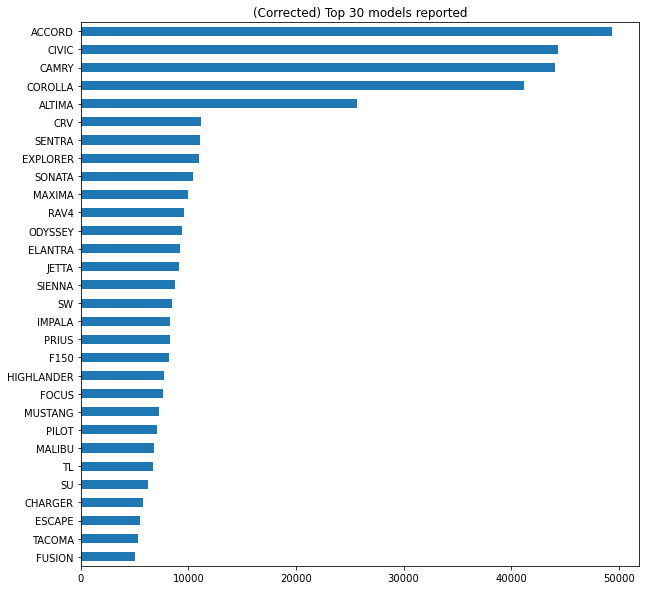

In [61]:
top_variants['SENTRA'] = [v for v in top_variants['SENTRA'] if v not in ['ELNTRA', 'EANTRA', '4SELANTRA']]
top_variants['ELANTRA'] = [v for v in top_variants['ELANTRA'] if v not in ['SOLANTRA', 'SALANTRA', 'ANTRA', 'ENTRA', 'SLANTRA']]
top_variants.pop('F150', None)

corrected_top_models = actual_models[:30].copy()
for k,variants in top_variants.items():
    corrected_top_models[k] += model_counts[variants[1:]].sum()

corrected_top_models.sort_values(inplace=True)
ax = corrected_top_models.plot(kind='barh', figsize=(10,10), title='(Corrected) Top 30 models reported')

Ultimately, the top five models — **Honda Accord**, **Honda Civic**, **Toyota Camry**, **Toyota Corolla**, and **Nissan Altima** — continue to be the top five models in approximately the same proportions, and substantially better-represented than anything else in the dataset, even after adjusting for (some of the) typos.